# Recommender Evaluation
### By Nicholas Roze-Freitas and Coby Wilcox

_To reduce boilerplate, code for visualizations and transformations can be found in visualization_modules.py and data_processing_modules.py respectively_

## Abstract
Recommender systems are an often behind the scenes but rather foundational aspect of life today. Usually when we engage with media, we are engaging with a recommender: using social media, reading the news, buying something online and much more. Regardless of how ubiquitous recommenders are, evaluating and making them presents interesting and unique problems. Recommenders get evaluated on several different metrics of accuracy: serendipity, novelty, robustness, accuracy and coverage to name a few. Through this project we evaluate the performance of several recommender system models and frameworks, and how we might improve them in the context of the Microsoft News Dataset. Through this report we start with an exploration of our dataset, create model pipelines and then evaluate and report findings. Below is an exploration of our dataset and its features.

## Exploratory data analysis

Before evaluating any recommender frameworks, models or hyperparameters, we will be engaging in exploratory data analysis on the Microsoft News Dataset. The Microsoft news dataset contains 4 separate tab-separated files: behaviors entity_embeddings, news and relation_embeddings. The main focus for now will be on behaviors and news, which gives us data on the catalog and users with interactions respectively. 

In [5]:
## IMPORTS ## REMOVE IMPORTS NOT EDA_MODULES ONCE DONE ##
import visualization_modules 
import data_processing_modules as data_processing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as datetime


### Changing file formats
We first noticed that our files were in unlabeled .tsv files, to make our data analysis easier in the future these .tsv files were turned into csvs with columns as specified by the datasets github repo. Once these columns were created, exploratory data analysis could be performed more easily.

### Initial understanding
Within the MIND dataset (might want to make it clear that the mind dataset is referring to the microsoft news dataset at some point so that it is more clear to the reader) there are two main files, the behaviors and news. News contains information on the articles that users interact with like its ID, category, sub-category, title, abstract, url and some entities for use within embeddings (to my understanding). Behaviors focuses on impression ids, user ids, time, user history and impressions. Since there are two main datasets, we will be starting with some examination of each, and then examination of how they might interact.

In [8]:
news = pd.read_csv('../MIND_small/csv/news.csv')
news.head(2)

,Unnamed: 0,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities
0,0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."


## Starting with news
As noticeable above, there are columns for categories and subcategories. As these categories will be utilized to improve recommendations we will start our analysis of the news dataset by taking a quick peak at how many categories there may be, and what sorts of sub-categories we'll find in each via a treemap. 

In [9]:
fig = visualization_modules.plot_sub_categories(news)
fig.show()

Within this initial peak we can see that our biggest categories are news and sports, whereas music, movies and entertainment make up the smallest. In content-filtering recommenders differing sizes of categories can lower the quality of recommendations as categories with more items are more likely to have higher counts of users that have interacted with them thus increasing the frequency that they are recommended. Consequently this can affected success metrics; improper management could cause a dip in coverage and serendipity as the recommender system will not make as wide a selection of recommendations. Through further analysis we can explore the option of applying an inverse category frequency weight to balance our recommendations within content-filtering recommenders.

### Checking Counts of Categories
Moving on, we will now check the distribution of our categories more properly.

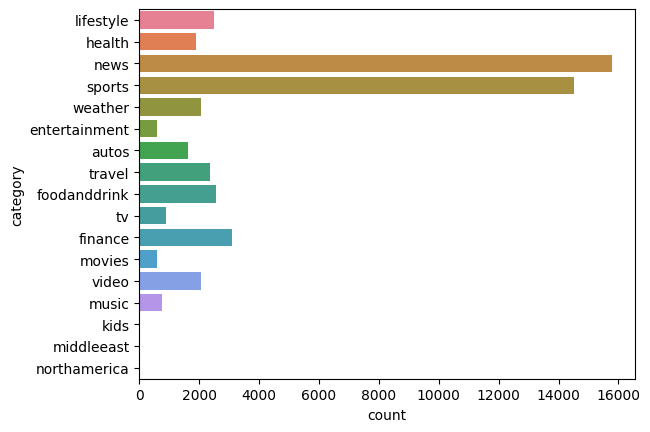

In [10]:
fig = visualization_modules.plot_categories(news)
# Might want to consider sorting so the figure can make better sense, also considering matching colors with the px graph above

Confirming what we saw earlier, news and sports are still our biggest main categories, however new categories not previoulsy seen in our peek such as kids, middleeast and northamerica appear. These latter 3 categories contain so few observations that its unlikely that a user has interacted with them. To ameliorate this, we will see if any users have interacted with articles from these categories and remove the categories depending on the results after we load in the behaviors data.

### Missing Values in News
Most missing values are in the abstract with only a few in title_entities and abstract_entities. An abstract briefly summarizes an articles content; by turning abstracts into embeddings we can create a feature that uses similarity of embeddings to recommend news. While there are missing many values we experimented with ignoring them altogether or utilizing a summarization model like T5 to generate new abstracts for the articles.

In [11]:
missing_vals = news.isna().sum()
missing_vals

Unnamed: 0              0
news_id                 0
category                0
sub_category            0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64

## Moving on to Behaviors
The other half of the Microsoft News Dataset is the behaviors file; detailing user interactions, history, and times, the behaviors file provides our recommenders important training data. Due to the inclusion of a timestamp for interactions we examined the temporal context of interactions and created traditional training and testing splits based off of time frames as detailed further below.

In [12]:
behaviors = pd.read_csv('../MIND_small/csv/behaviors.csv')
behaviors.head(2)

,Unnamed: 0,impression_id,user_id,time,history,impressions
0,0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...


### Missing values in behaviors
Before showcasing more of our analysis we first discuss the missing values in behaviors.

In [13]:
behaviors.isna().sum()

Unnamed: 0          0
impression_id       0
user_id             0
time                0
history          3238
impressions         0
dtype: int64

The only column containing missing values is the history column which can have an effect on the efficacy of a sequential recommender. As it is the history column, this implies that there are new users who's first interactions have been logged and have yet to have a history. (look more into history column). This creates a major issue for sequential recommenders, which utilize a users history to create new recommendations. 

When evaluating the Tensorflow sequential recommender, we removed rows that included missing values for history. For other recommender models we added a layer that was able to provide recommendations based off of other features.

### Article and Category Popularity
We then analyzed the popularity of each category and article in the dataset. Each interaction in the dataset has information specific to that interaction: prior history and clickthrough rates for recommended articles. From this, we determined the popularity of articles and categories in regards to history, clickthrough rate and both. Code relating to the extrapolation of this data can be found in data_processing_modules.py.

### Categories
By checking the popularity of categories we can 

/Users/nick/miniforge3/envs/recSysEnv/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



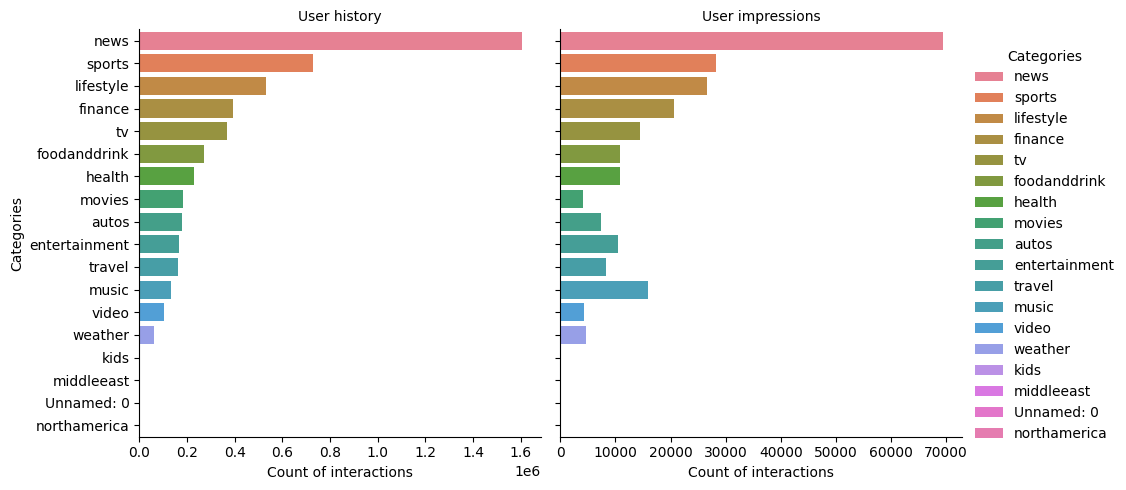

In [14]:
category_popularity = pd.read_csv('../MIND_small/csv/category_with_popularity.csv')
visualization_modules.plot_category_popularity(category_popularity) # Add order to the barplot function
# Remove the unnamed: 0 column from the dataframe again in plot_category_popularity

As visible above, the count of articles in a category does not impact the overall popularity of that category. TV has less articles than weather and yet is much more popular amongst users. It's clear from earlier distribitutions that certain categories have larger catalogs and popularity. To see if category and popularity density affects the quality of recommendations we later experiment with a potential weighting system modeled after IDF with categories that are more prevalent. 

### analyzing the categories a user likes in relation to their other categories

In [33]:
category_popularity = pd.read_csv('../MIND_small/csv/category_with_popularity.csv')

In [40]:
category_popularity.drop(columns=['popularity_type'], inplace=True)
category_popularity.columns

Index(['lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment',
       'autos', 'travel', 'foodanddrink', 'tv', 'finance', 'movies', 'video',
       'music', 'kids', 'middleeast', 'northamerica'],
      dtype='object')

In [37]:
print(category_popularity.columns.to_list())

['popularity_type', 'lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment', 'autos', 'travel', 'foodanddrink', 'tv', 'finance', 'movies', 'video', 'music', 'kids', 'middleeast', 'northamerica']


In [42]:
news = pd.read_csv('../MIND_small/csv/news.csv')
copynews = news.set_index('news_id')
def get_hourly_popularity(row, history=True):
    """
    BASED OFF OF IMPRESSION RN AND NOT HISTORY, MIGHT WANT TO DO THE SAME: Gets the hourly popularity for the categories by getting the rows impressions column 
    FOR ARTICLE HOURLY TIME POPULARITY IS MORE DIFFICULT AND WILL NEED TO BE DONE WITH A FULL DATE PROBABLY (annoying :<)
    """
    # Read in the news csv and set its index to news_id.


    # Create dictionaries to store interacted categories for each user by history and their clickthrough rates.
    category_popularity_impression = {category: 0 for category in pd.unique(copynews['category'])}
    category_popularity_history = {category: 0 for category in pd.unique(copynews['category'])}

    # Get the history and impressions of the user in the row.
        
    if history:
        history=row['history']
        # If our history is not a NaN.
        if type(history) != float:

            # Split the history into news IDs
            for news_id in history.split():

                # Locate the article and access its category, then increment the metrics.
                category = copynews.loc[news_id]['category']
                category_popularity_history[category] += 1
    else:
        impressions=row['impressions']
        # If the impression is not a NaN.
        if type(impressions) != float:
            # Access all impressions.
            for impression in impressions.split():

                # Clean up the impression so that it's easier to parse.
                impression_info = data_processing.clean_impression(impression)

                # If the impression signifies a clickthrough increment the metrics.
                if impression_info['score'] == '1':
                    category = copynews.loc[impression_info['article_ID']]['category']
                    category_popularity_impression[category] += 1

    return category_popularity_history if history else category_popularity_impression

# print(pd.unique(copynews['category']))
behaviors[category_popularity.columns.to_list()] = behaviors.apply(lambda row : get_hourly_popularity(row, True), axis='columns', result_type='expand')


,Unnamed: 0,impression_id,user_id,time,history,impressions,lifestyle,health,news,sports,...,travel,foodanddrink,tv,finance,movies,video,music,kids,middleeast,northamerica
0,0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,1,0,3,2,...,0,0,2,0,1,0,0,0,0,0
1,1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,5,1,54,3,...,5,3,0,5,1,1,1,0,0,0
2,2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,5,0,2,4,...,0,1,1,1,0,0,0,0,0,0
3,3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,1,0,0,4,...,0,0,2,2,0,1,0,0,0,0
4,4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156960,156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...,4,1,29,3,...,3,0,1,10,1,4,0,0,0,0
156961,156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...,4,0,6,6,...,1,1,3,5,2,0,3,0,0,0
156962,156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...,1,0,4,2,...,2,8,0,5,0,0,0,0,0,0
156963,156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...,11,5,20,1,...,0,1,3,3,3,3,1,0,0,0


In [43]:
behaviors.rename(columns={column : column + "_history" for column in category_popularity.columns.to_list()}, inplace=True)
behaviors

,Unnamed: 0,impression_id,user_id,time,history,impressions,lifestyle_history,health_history,news_history,sports_history,...,travel_history,foodanddrink_history,tv_history,finance_history,movies_history,video_history,music_history,kids_history,middleeast_history,northamerica_history
0,0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,1,0,3,2,...,0,0,2,0,1,0,0,0,0,0
1,1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,5,1,54,3,...,5,3,0,5,1,1,1,0,0,0
2,2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,5,0,2,4,...,0,1,1,1,0,0,0,0,0,0
3,3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,1,0,0,4,...,0,0,2,2,0,1,0,0,0,0
4,4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156960,156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...,4,1,29,3,...,3,0,1,10,1,4,0,0,0,0
156961,156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...,4,0,6,6,...,1,1,3,5,2,0,3,0,0,0
156962,156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...,1,0,4,2,...,2,8,0,5,0,0,0,0,0,0
156963,156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...,11,5,20,1,...,0,1,3,3,3,3,1,0,0,0


In [2]:
behaviors[category_popularity.columns.to_list()] = behaviors.apply(lambda row : get_hourly_popularity(row, False), axis='columns', result_type='expand')
behaviors.rename(columns={column : column + "_impression" for column in category_popularity.columns.to_list()}, inplace=True)
behaviors

NameError: name 'behaviors' is not defined

In [1]:
behaviors

NameError: name 'behaviors' is not defined

### Addressing the Long Tail
Something that can arise when creating recommenders is the long tail problem; an issue where certain items have a disproportionate number of ratings which can skew recommendations. As visible in the distributions of popularity for both categories and specific articles, there is a long tail. To ameliorate this we experimented with different methods of applying a pseudo-idf to categories and articles to help lesser known articles appear more in recommendations.

## Accessing temporal aspects of our data
Within our data we have a time column, meaning that we can not only test and train with time in mind, but we can utilize this temporal aspect in our recommendations. As a result of this potential we have access to creating feature interactions based off of an interaction time. 

In [11]:

copynews = news.set_index('news_id') # duplicate copynews will have to fix later!
times = [behaviors['time'].max(), behaviors['time'].min()]

cut_points = pd.date_range(start='2019-11-09 00:00:00', end='2019-11-15 00:00:00', freq='h') # hourly ranges for the time of the behaviors dataset

behaviors_new = behaviors.copy()
bins_str = cut_points.astype(str).values

labels = ['({}, {}]'.format(bins_str[i-1], bins_str[i]) for i in range(1, len(bins_str))]
print(labels)
behaviors_new['time'] = pd.cut(behaviors['time'], cut_points, labels=labels, include_lowest=True)
behaviors_new['time'] = behaviors_new['time'].apply(lambda time_string : time_string.split(" ")[-1][:-1])
STANDARD_DICT = {category: 0 for category in pd.unique(copynews['category'])}
def func(row):
    """ 
    Might want to change name from impression to interaction
    """
    user_interactions = row['impressions']
    cols_to_add = STANDARD_DICT.copy()
    if type(user_interactions) != float:
        for impression in user_interactions.split():
            impression_info = clean_impression(impression)
            if impression_info['score'] == '1':
                cols_to_add[copynews.loc[impression_info['article_ID']]['category']] += 1
    return cols_to_add

# print([category_popularity.columns.to_list()])
behaviors_new[category_popularity.columns.to_list()] = behaviors_new.apply(lambda row : func(row), axis='columns', result_type='expand')

# breaking down whats going on in this code chunk
def modify_hourly(behaviors):
    """
    Bins the time column of behaviors into hours so that insights on how time of day affects category popularity can be examined.
    
    Args:
        behaviors (pd.DataFrame) : Dataframe of the behaviors csv.

    Returns:
        behaviors (pd.DataFrame) : Behaviors dataframe modified to include a binned time column. 
    """
    # get the time frame for the dataset to be applied in cutpoints
    times = [behaviors['time'].max(), behaviors['time'].min()]
    # going to want to set it so that time is only representing the date of the week and not hours, so cut_points can join the date with 00:00:00 for hourly predictions
    
    cut_points = pd.date_range(start='2019-11-09 00:00:00', end='2019-11-15 00:00:00', freq='h') # hourly ranges for the time of the behaviors dataset
    # going to want to adjust cutpoints so that we are specifically thinking of hours from 1 - 24 with 24 being midnight (0)
    
    # Create labels for the bins.
    bins_str = cut_points.astype(str).values
    labels = ['({}, {}]'.format(bins_str[i-1], bins_str[i]) for i in range(1, len(bins_str))]
    
    # Apply the bins to the time column.
    behaviors['hours'] = pd.cut(behaviors['time'], cut_points, labels=labels, include_lowest=True)
    
    # Modify the times so that it is only hours.
    behaviors['hours'] = behaviors['time'].apply(lambda time_string : time_string.split(" ")[-1][:-1])


def get_hourly_popularity(row):
    """
    BASED OFF OF IMPRESSION RN AND NOT HISTORY, MIGHT WANT TO DO THE SAME: Gets the hourly popularity for the categories by getting the rows impressions column 
    FOR ARTICLE HOURLY TIME POPULARITY IS MORE DIFFICULT AND WILL NEED TO BE DONE WITH A FULL DATE PROBABLY (annoying :<)
    """
    # Read in the news csv and set its index to news_id.
    news = pd.read_csv('../MIND_small/csv/news.csv')
    copynews = news.set_index('news_id')

    # Create dictionaries to store interacted categories for each user by history and their clickthrough rates.
    category_popularity_impression = {category: 0 for category in pd.unique(copynews['category'])}
    category_popularity_history = {category: 0 for category in pd.unique(copynews['category'])}

    # Get the history and impressions of the user in the row.
    for history, impressions in zip(row['history'], row['impressions']):

        # If our history is not a NaN.
        if type(history) != float:

            # Split the history into news IDs
            for news_id in history.split():

                # Locate the article and access its category, then increment the metrics.
                category = copynews.loc[news_id]['category']
                category_popularity_history[category] += 1

        # If the impression is not a NaN.
        if type(impressions) != float:
            # Access all impressions.
            for impression in impressions.split():

                # Clean up the impression so that it's easier to parse.
                impression_info = clean_impression(impression)

                # If the impression signifies a clickthrough increment the metrics.
                if impression_info['score'] == '1':
                    category = copynews.loc[impression_info['article_ID']]['category']
                    category_popularity_impression[category] += 1

    return pd.Series(category_popularity_impression), pd.Series(category_popularity_history)

    

# start by creating a copy of the news with its category as index
# create an array called times with the maximum and minimum time of the time column 
# then create cutpoints for the date-range of the dataset
# then make a list of strings from the bins
# then create a list of labels from the bins
# then set the time to be the bins
# set the time string to be only hours
# create a standard dictionary of all categories
# add the popularity for the times based off of users in behaviors


# popularity_by_time[[category_popularity.columns]] = popularity_by_time.apply(lambda row : func(row))
# might just want to create a new dataframe with history and time 

['(2019-11-09 00:00:00, 2019-11-09 01:00:00]', '(2019-11-09 01:00:00, 2019-11-09 02:00:00]', '(2019-11-09 02:00:00, 2019-11-09 03:00:00]', '(2019-11-09 03:00:00, 2019-11-09 04:00:00]', '(2019-11-09 04:00:00, 2019-11-09 05:00:00]', '(2019-11-09 05:00:00, 2019-11-09 06:00:00]', '(2019-11-09 06:00:00, 2019-11-09 07:00:00]', '(2019-11-09 07:00:00, 2019-11-09 08:00:00]', '(2019-11-09 08:00:00, 2019-11-09 09:00:00]', '(2019-11-09 09:00:00, 2019-11-09 10:00:00]', '(2019-11-09 10:00:00, 2019-11-09 11:00:00]', '(2019-11-09 11:00:00, 2019-11-09 12:00:00]', '(2019-11-09 12:00:00, 2019-11-09 13:00:00]', '(2019-11-09 13:00:00, 2019-11-09 14:00:00]', '(2019-11-09 14:00:00, 2019-11-09 15:00:00]', '(2019-11-09 15:00:00, 2019-11-09 16:00:00]', '(2019-11-09 16:00:00, 2019-11-09 17:00:00]', '(2019-11-09 17:00:00, 2019-11-09 18:00:00]', '(2019-11-09 18:00:00, 2019-11-09 19:00:00]', '(2019-11-09 19:00:00, 2019-11-09 20:00:00]', '(2019-11-09 20:00:00, 2019-11-09 21:00:00]', '(2019-11-09 21:00:00, 2019-11-09

In [25]:

behaviors_final = behaviors_new.drop(columns=['Unnamed: 0', 'impression_id', 'user_id', 'history', 'impressions'])
                

behaviors_final = behaviors_final.groupby('time').agg('sum')
behaviors_final.reset_index(inplace=True)

/var/folders/83/h9nx83394pb5k_0h4zbb4lw00000gn/T/ipykernel_10514/1544821908.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,time,variable,value
0,0,lifestyle,185
1,1,lifestyle,146
2,2,lifestyle,169
3,3,lifestyle,251
4,4,lifestyle,446
...,...,...,...
403,19,northamerica,1
404,20,northamerica,0
405,21,northamerica,0
406,22,northamerica,0


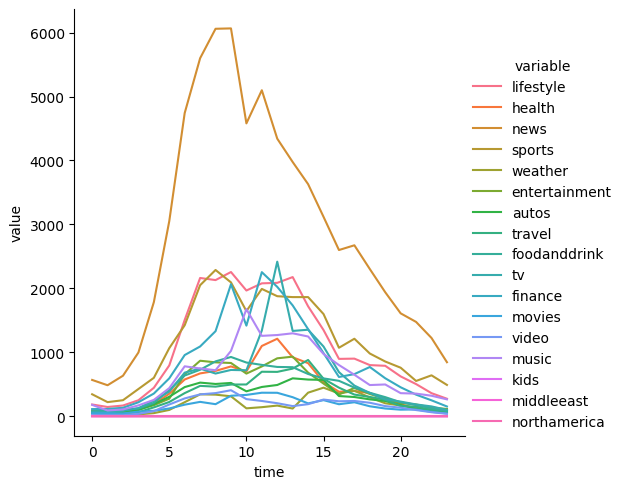

In [52]:


cols = ['lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment', 'autos', 'travel', 'foodanddrink', 'tv', 'finance', 'movies', 'video', 'music', 'kids', 'middleeast', 'northamerica']
behaviors_long = behaviors_final.melt(id_vars='time', value_vars=cols)
behaviors_long['time'] = pd.to_datetime(behaviors_long['time'])
behaviors_long['time'] = behaviors_long['time'].dt.hour

sns.relplot(behaviors_long, x='time', y='value', hue='variable', kind='line')
behaviors_long

###  meep
Within the context of a recommender we do not care about the date exactly but more so the hour or time of day, hence we will change the bins accordingly 